# Baseline Model

## Table of Contents
1. [Model Choice](#model-choice)
2. [Feature Selection](#feature-selection)
3. [Implementation](#implementation)
4. [Evaluation](#evaluation)


In [1]:
import sys
import math
import warnings
import itertools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

sys.path.append('../')
from Data.load_data import get_input_data
from utils import search_optimal_params

# viz configs
from matplotlib import rcParams
import seaborn as sns
rcParams["figure.figsize"] = 25, 8
rcParams["timezone"] = "UTC"
sns.set_style("whitegrid")

## Model Choice

Auto regressive Integrated Moving Average(ARIMA) models are classical statistical models. These models are used to assess the dataset, initial modeling and ultimately comparison against advanced and more SOTA models.

Considering **Seasonal ARIMA**


## Feature Selection

[Indicate which features from the dataset you will be using for the baseline model, and justify your selection.]


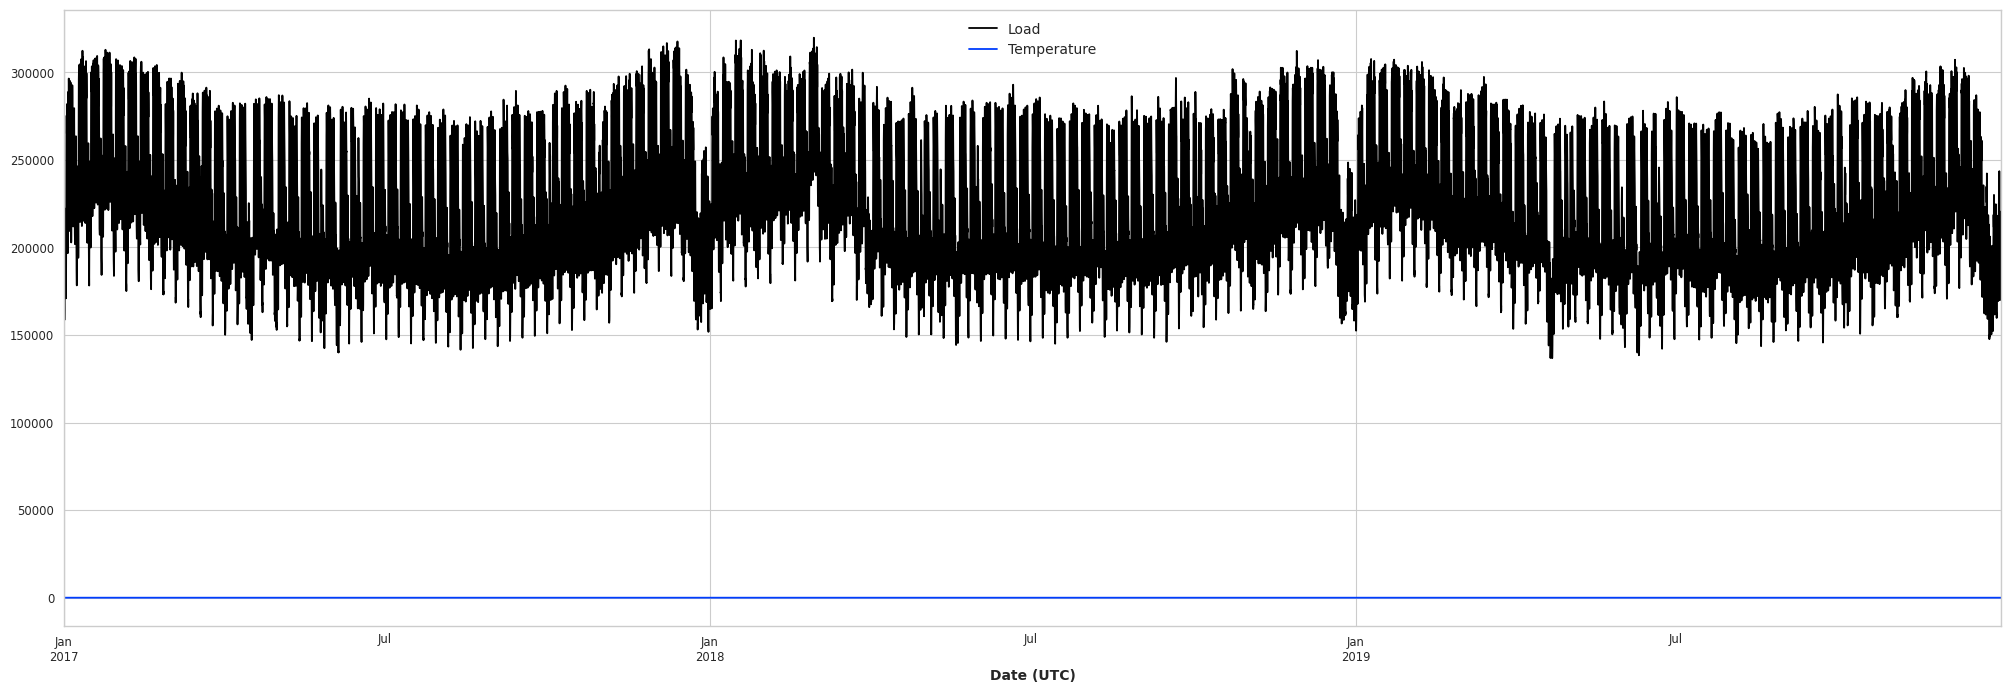

In [2]:
data_frame = get_input_data()
data_frame.plot()
plt.show()

In [3]:
data_frame['hour'] = data_frame.index.hour
data_frame['day_of_week'] = data_frame.index.day_of_week
# data_frame['day'] = data_frame.index.day
# data_frame['month'] = data_frame.index.month
data_frame['day_of_year'] = data_frame.index.dayofyear
data_frame['is_weekend'] = data_frame.index.weekday // 5
# data_frame['is_holiday']
data_frame.tail(2)

,Load,Temperature,hour,day_of_week,day_of_year,is_weekend
Date (UTC),,,,,,
2019-12-31 21:00:00+00:00,187248.1,0.6,21,1,365,0
2019-12-31 22:00:00+00:00,179641.0,0.2,22,1,365,0


In [4]:
load_df = data_frame["Load"]
sub_df = load_df[-1000:]

**Rolling Mean and Standard Deviation**

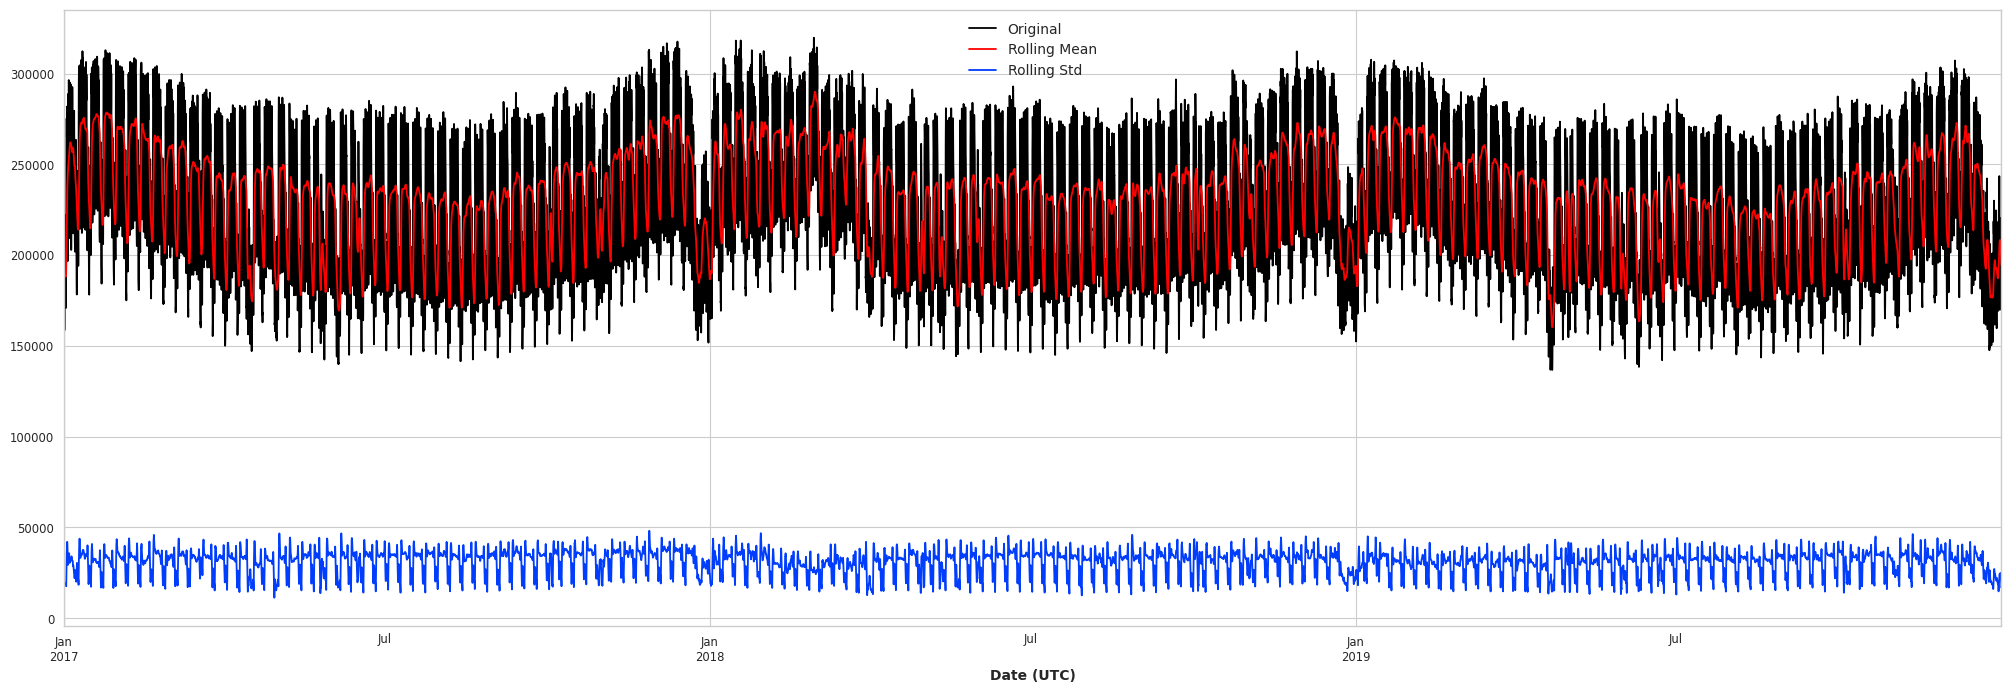

In [5]:
# plotting rolling mean and standard deviation
load_df.plot(label="Original")
load_df.rolling(24).mean().plot(label="Rolling Mean", c="r")
load_df.rolling(24).std().plot(label="Rolling Std")
plt.legend()
plt.show()

**Additive Decomposition**

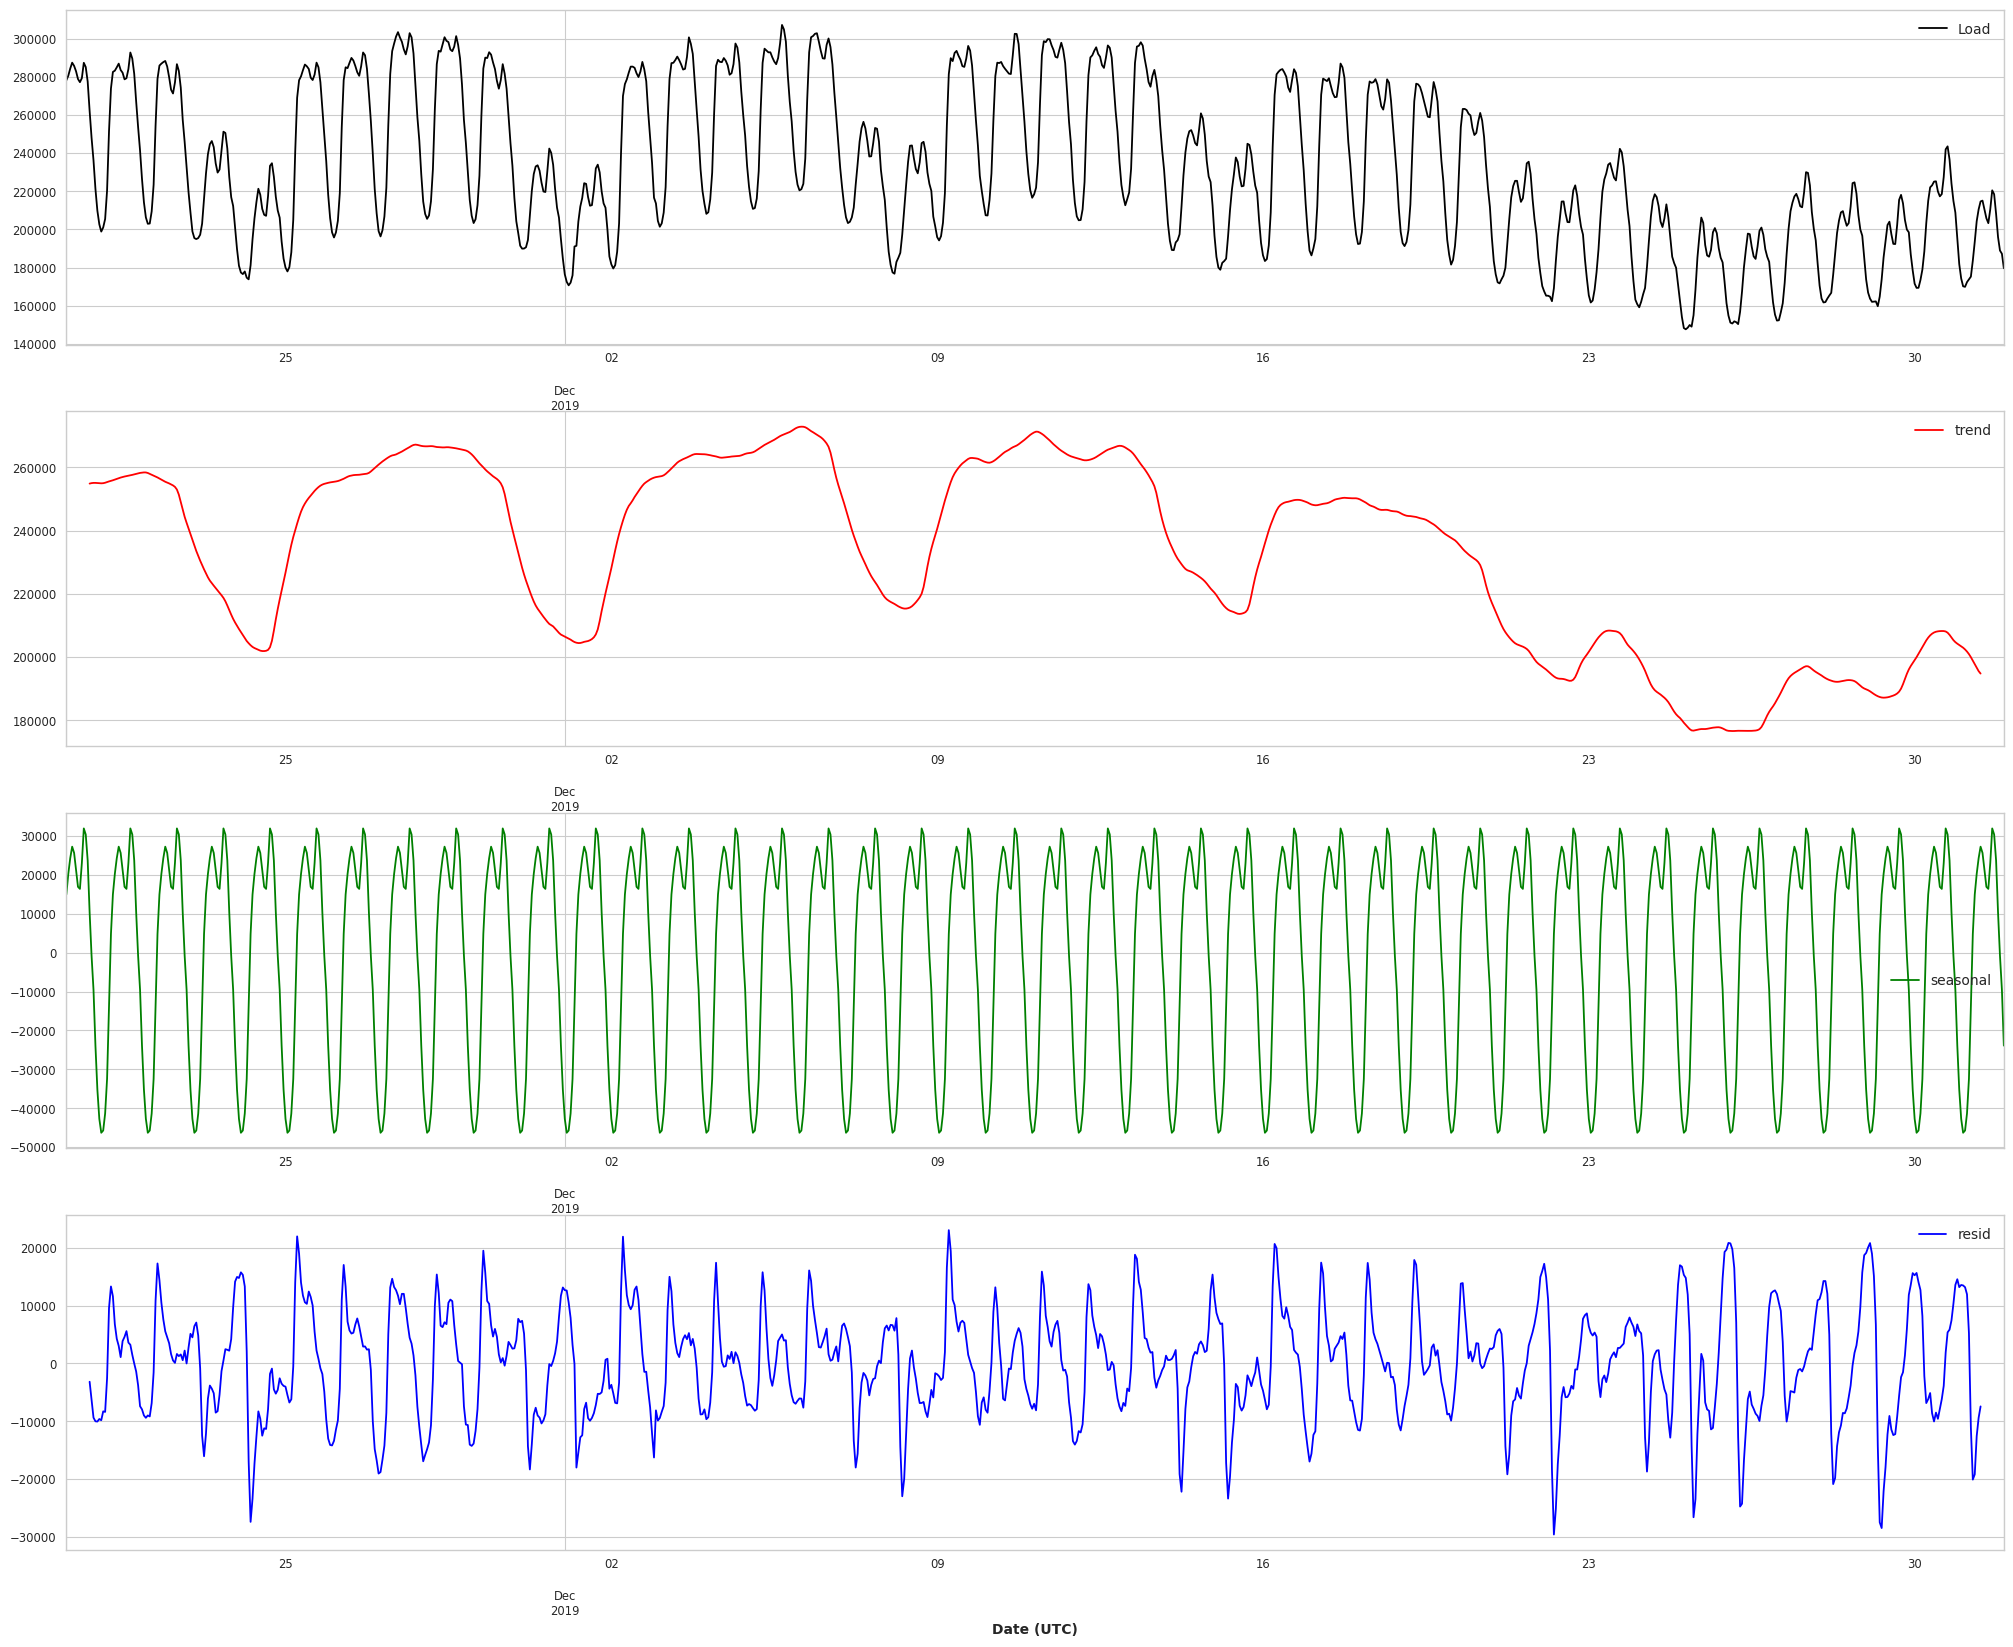

In [6]:
decomposition = sm.tsa.seasonal_decompose(sub_df, model='additive', period=24)

fig, ax = plt.subplots(4, 1, figsize=(25, 20))
sub_df.plot(ax=ax[0], legend='Original')
decomposition.trend.plot(ax=ax[1], c='r', legend='Trend')
decomposition.seasonal.plot(ax=ax[2], c='g', legend='Seasonal')
decomposition.resid.plot(ax=ax[3], c='b', legend='Residual')
plt.legend()
plt.show()

**Stationarity**

In [7]:
warnings.filterwarnings("ignore")
from statsmodels.tsa.stattools import adfuller, kpss

def is_stationary(data_frame: pd.DataFrame) -> bool:
    result_adf = adfuller(data_frame)
    result_kpss = kpss(data_frame)

    return (result_adf[1] < 0.05) and (result_kpss[1] > 0.05)

print("stationarity on data: {}".format(is_stationary(load_df)))

stationarity on data: False


**correlations**

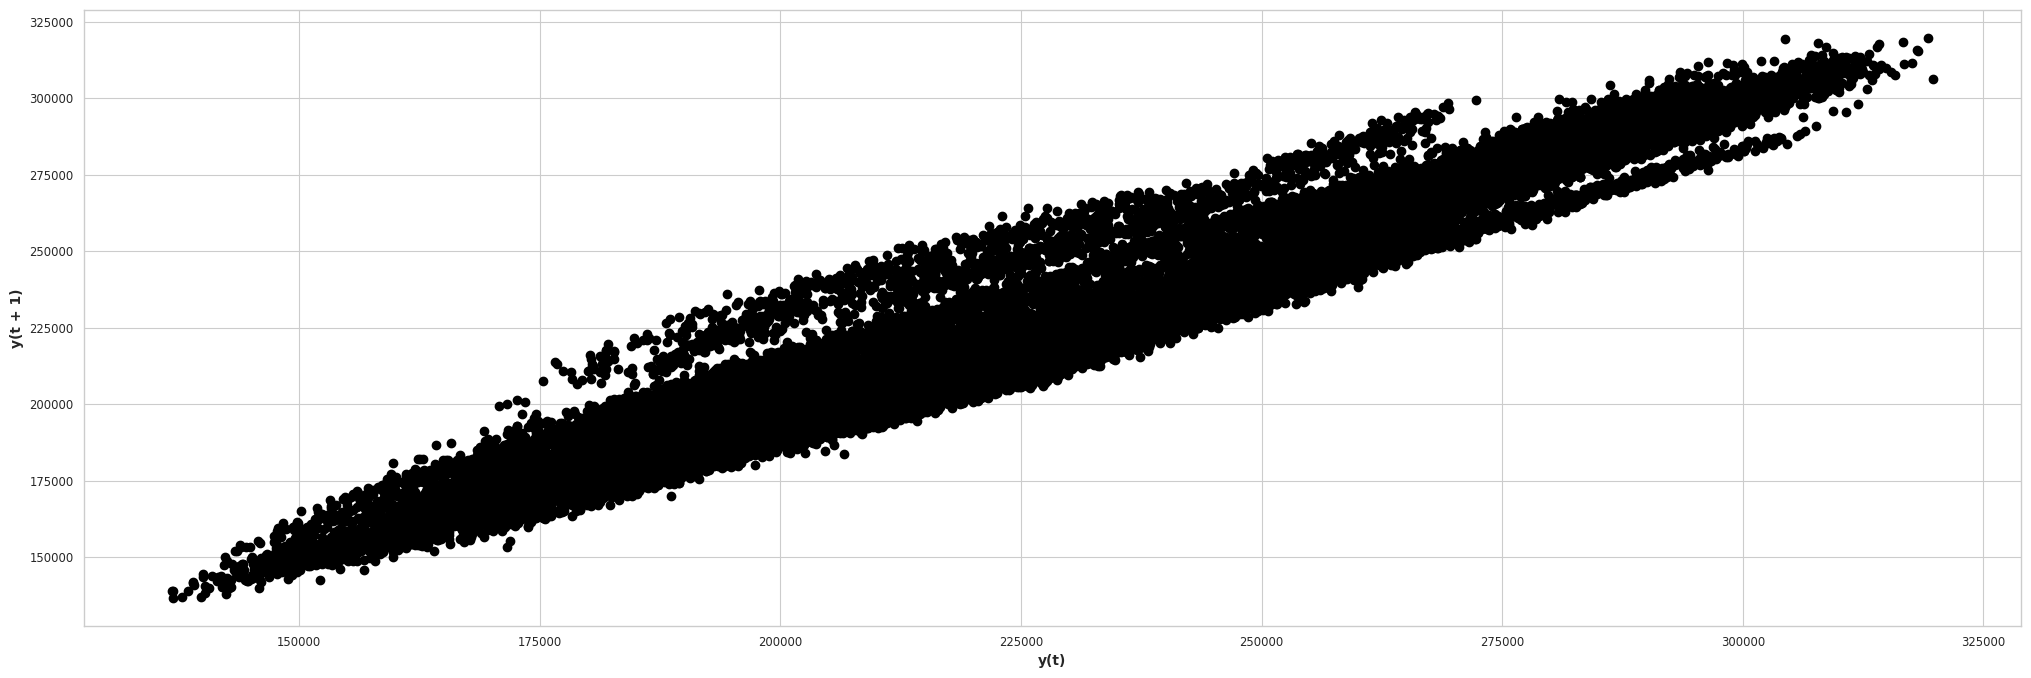

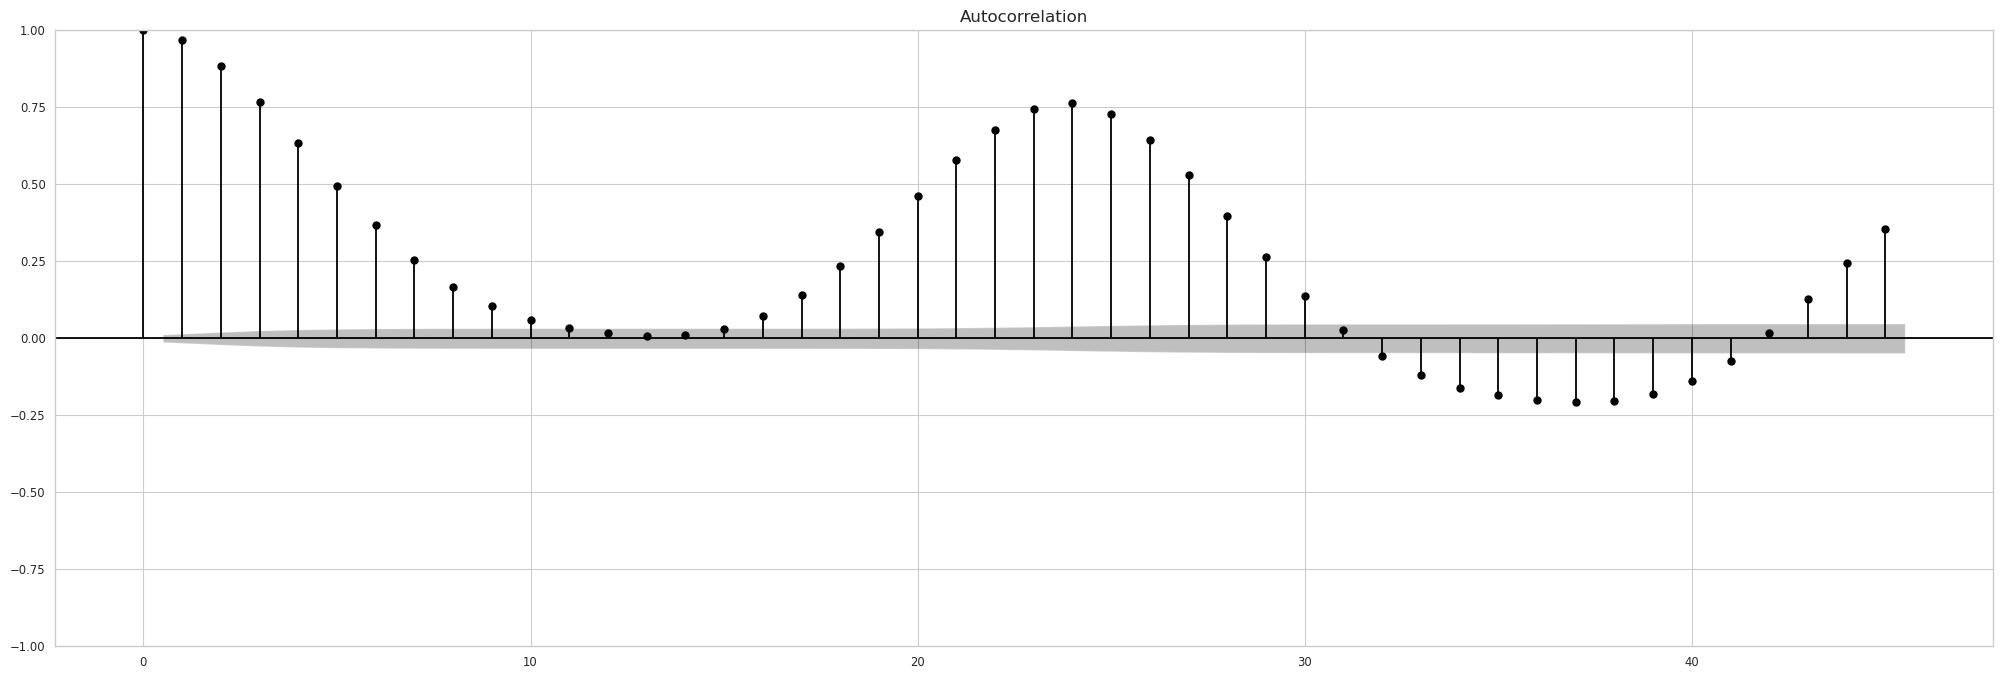

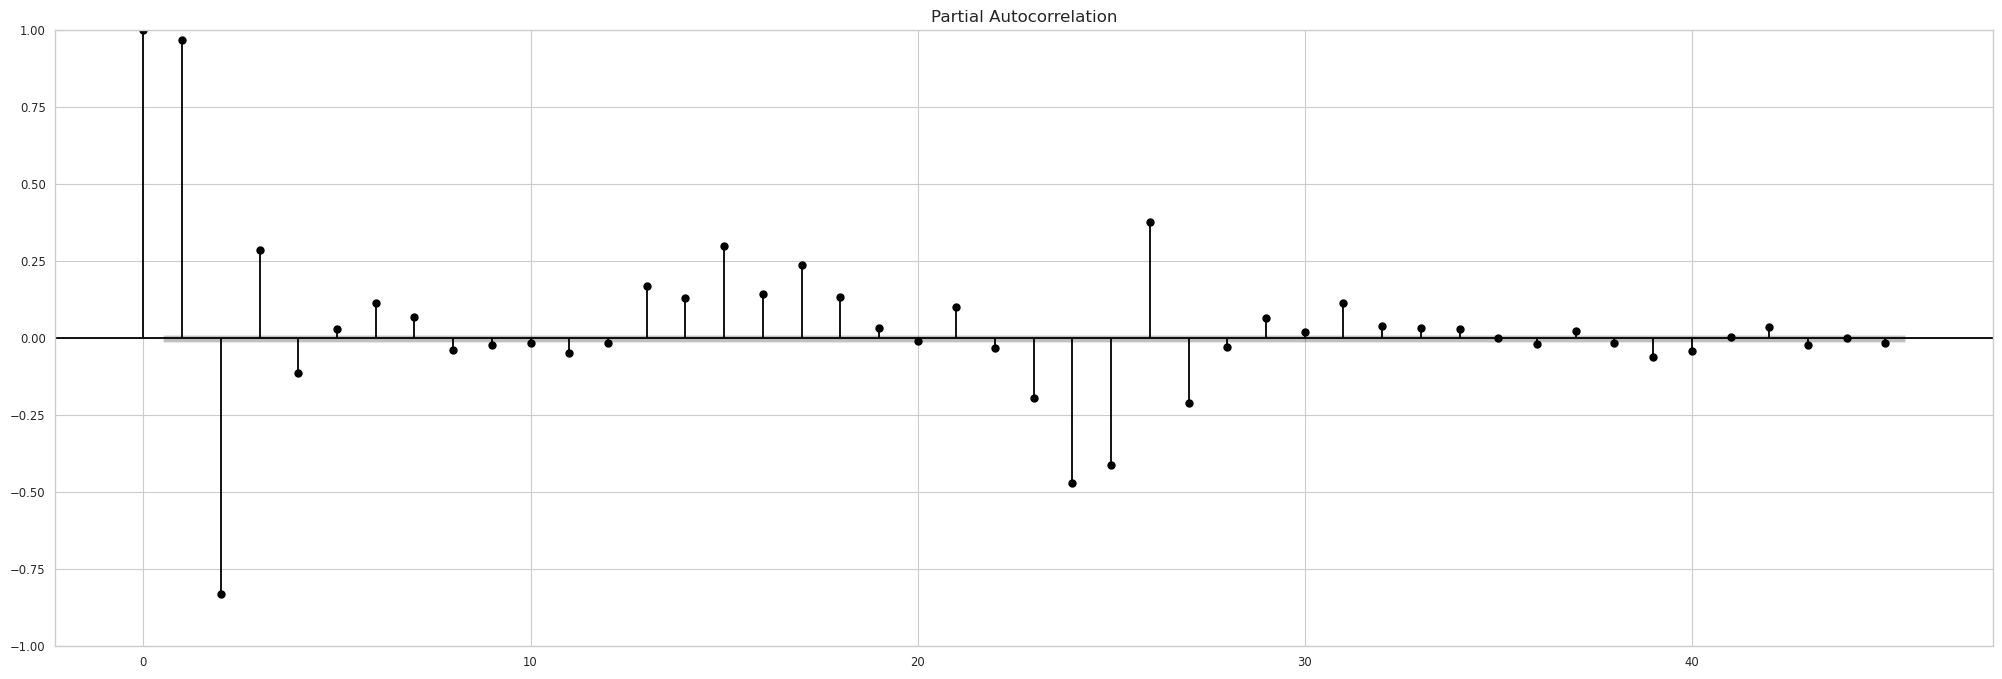

In [8]:
from pandas.plotting import lag_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

lag_plot(load_df)
plt.show()

plot_acf(load_df)
plt.show()

plot_pacf(load_df)
plt.show()

**train-test set**

In [9]:
split_point = int(len(data_frame) * 0.9)
train_set, test_set = data_frame[:split_point], data_frame[split_point:]
print("train set: {}, test set: {}".format(len(train_set), len(test_set)))

train set: 23652, test set: 2628


## Implementation

In [10]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pma

**Grid Search | Parameter Optimization**

In [11]:
warnings.filterwarnings("ignore")

p_values = range(0, 2)  # Autoregressive order
d_values = range(0, 2)  # Differencing order
q_values = range(0, 2)  # Moving average order
P_values = range(0, 2)  # Seasonal autoregressive order
D_values = range(0, 1)  # Seasonal differencing order
Q_values = range(0, 2)  # Seasonal moving average order
m_values = [24]         # Seasonal period : daily

param_combinations = list(itertools.product(
    p_values, d_values,  q_values,
    P_values, D_values,  Q_values,
    m_values
))

best_params, best_aic = search_optimal_params(param_combinations, train_set)

order: (0, 0, 0), seasonal_order: (0, 0, 0, 24), AIC: 829680.2022886367
order: (0, 0, 0), seasonal_order: (0, 0, 1, 24), AIC: 599411.0314610889
order: (0, 0, 0), seasonal_order: (1, 0, 0, 24), AIC: 530006.7709425632
order: (0, 0, 0), seasonal_order: (1, 0, 1, 24), AIC: 565064.2612868703
order: (0, 0, 1), seasonal_order: (0, 0, 0, 24), AIC: 600086.0809243091
order: (0, 0, 1), seasonal_order: (0, 0, 1, 24), AIC: 591221.0146031615
order: (0, 0, 1), seasonal_order: (1, 0, 0, 24), AIC: 588026.8318810113
order: (0, 0, 1), seasonal_order: (1, 0, 1, 24), AIC: 588028.7771590333
order: (0, 1, 0), seasonal_order: (0, 0, 0, 24), AIC: 715114.4154949866
order: (0, 1, 0), seasonal_order: (0, 0, 1, 24), AIC: 483667.6102922516
order: (0, 1, 0), seasonal_order: (1, 0, 0, 24), AIC: 471998.3113701617
order: (0, 1, 0), seasonal_order: (1, 0, 1, 24), AIC: 465022.3524178687
order: (0, 1, 1), seasonal_order: (0, 0, 0, 24), AIC: 482948.38626254885
order: (0, 1, 1), seasonal_order: (0, 0, 1, 24), AIC: 469798.70

**Seasonal ARIMA**

In [14]:
# exogenous = train_set[['Temperature','hour', 'day_of_week', 'day', 'month', 'day_of_year', 'is_weekend']]
exogenous = train_set[['Temperature','hour', 'is_weekend']]
print(best_params, best_aic)

453218.6230099265 (1, 1, 1, 1, 0, 1, 24)


In [15]:
best_params = [1, 1, 1, 1, 0, 1, 24]

model = sm.tsa.SARIMAX(
    endog=train_set["Load"],
    exog=exogenous,
    order=best_params[:3],
    seasonal_order=best_params[3:]
)
result = model.fit(disp=False)
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                               Load   No. Observations:                23652
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 24)   Log Likelihood             -226601.312
Date:                            Tue, 30 Jan 2024   AIC                         453218.623
Time:                                    11:11:08   BIC                         453283.192
Sample:                                12-31-2016   HQIC                        453239.578
                                     - 09-13-2019                                         
Covariance Type:                              opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Temperature  4273.5065     88.669     48.196      0.000    4099.719    4447.295
hour          233.0668      9.657     24.136      0.000     214.140     251.993
is_weekend  -1247.6849    172.494     -7.233      0.000   -1585.767    -909.602
ar.L1           0.4508      0.002    220.701      0.000       0.447       0.455
ma.L1           0.3923      0.002    166.307      0.000       0.388       0.397
ar.S.L24        0.9856      0.000   2299.226      0.000       0.985       0.986
ma.S.L24       -0.8299      0.002   -366.404      0.000      -0.834      -0.825
sigma2       1.213e+07      0.035   3.49e+08      0.000    1.21e+07    1.21e+07
===================================================================================
Ljung-Box (L1) (Q):                  35.80   Jarque-Bera (JB):            674769.56
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.68   Skew:                            -0.80
Prob(H) (two-sided):                  0.00   Kurtosis:                        29.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.82e+22. Standard errors may be unstable.
"""

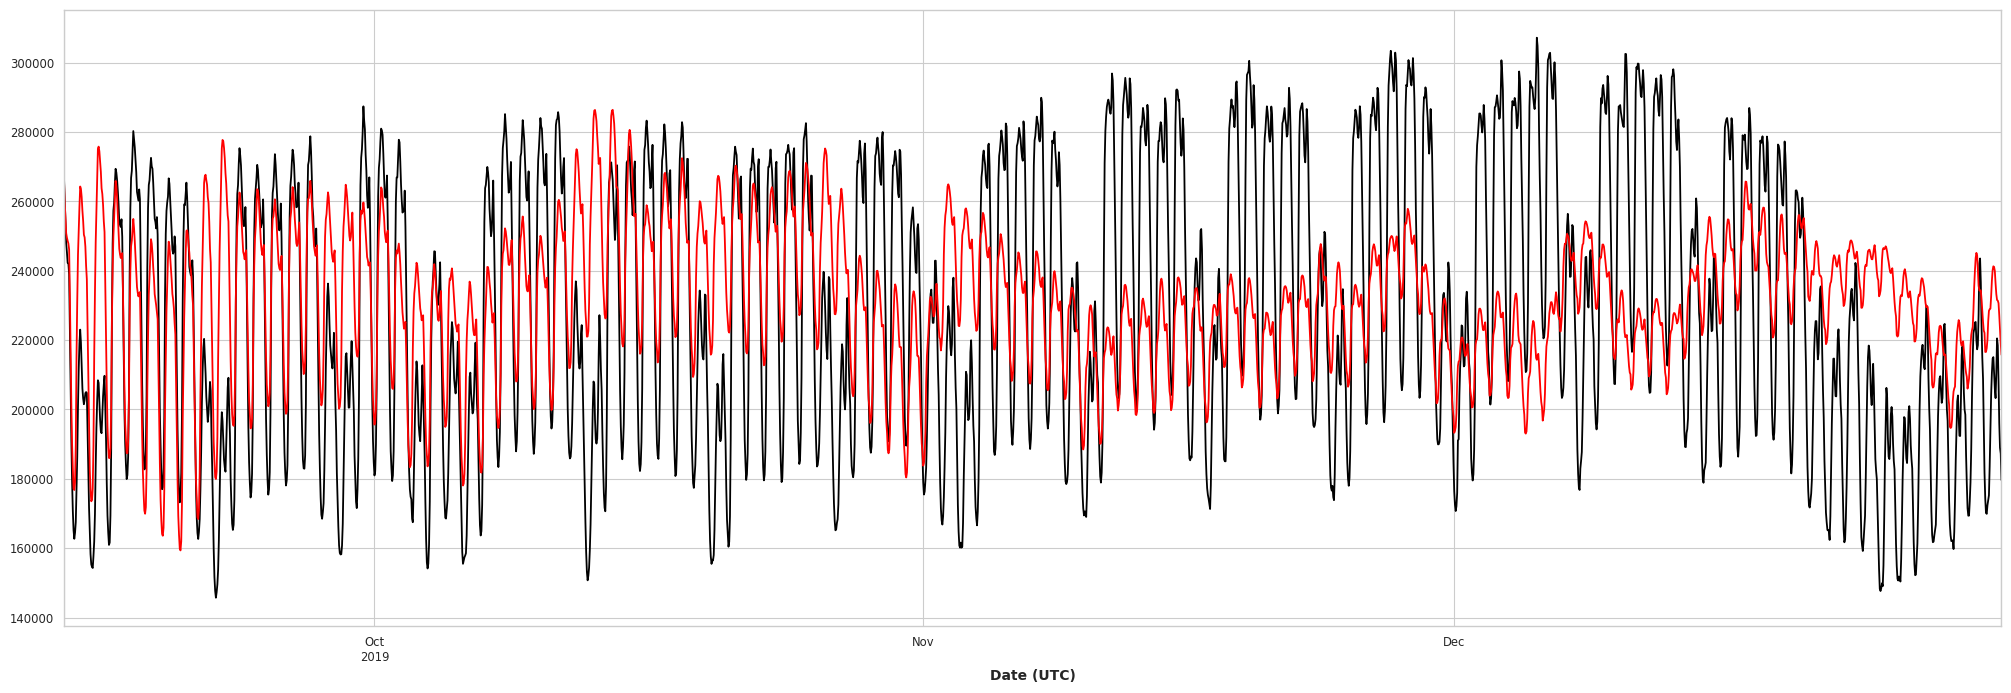

In [22]:
sarimax_prediction = result.get_prediction(
    start=test_set.index[0], end=test_set.index[-1],
    exog=test_set[['Temperature','hour', 'is_weekend']],
).predicted_mean

test_set["Load"][].plot()
sarimax_prediction.plot(color='red')
plt.show()

**Shorter window** `First Two-Weeks of test set`

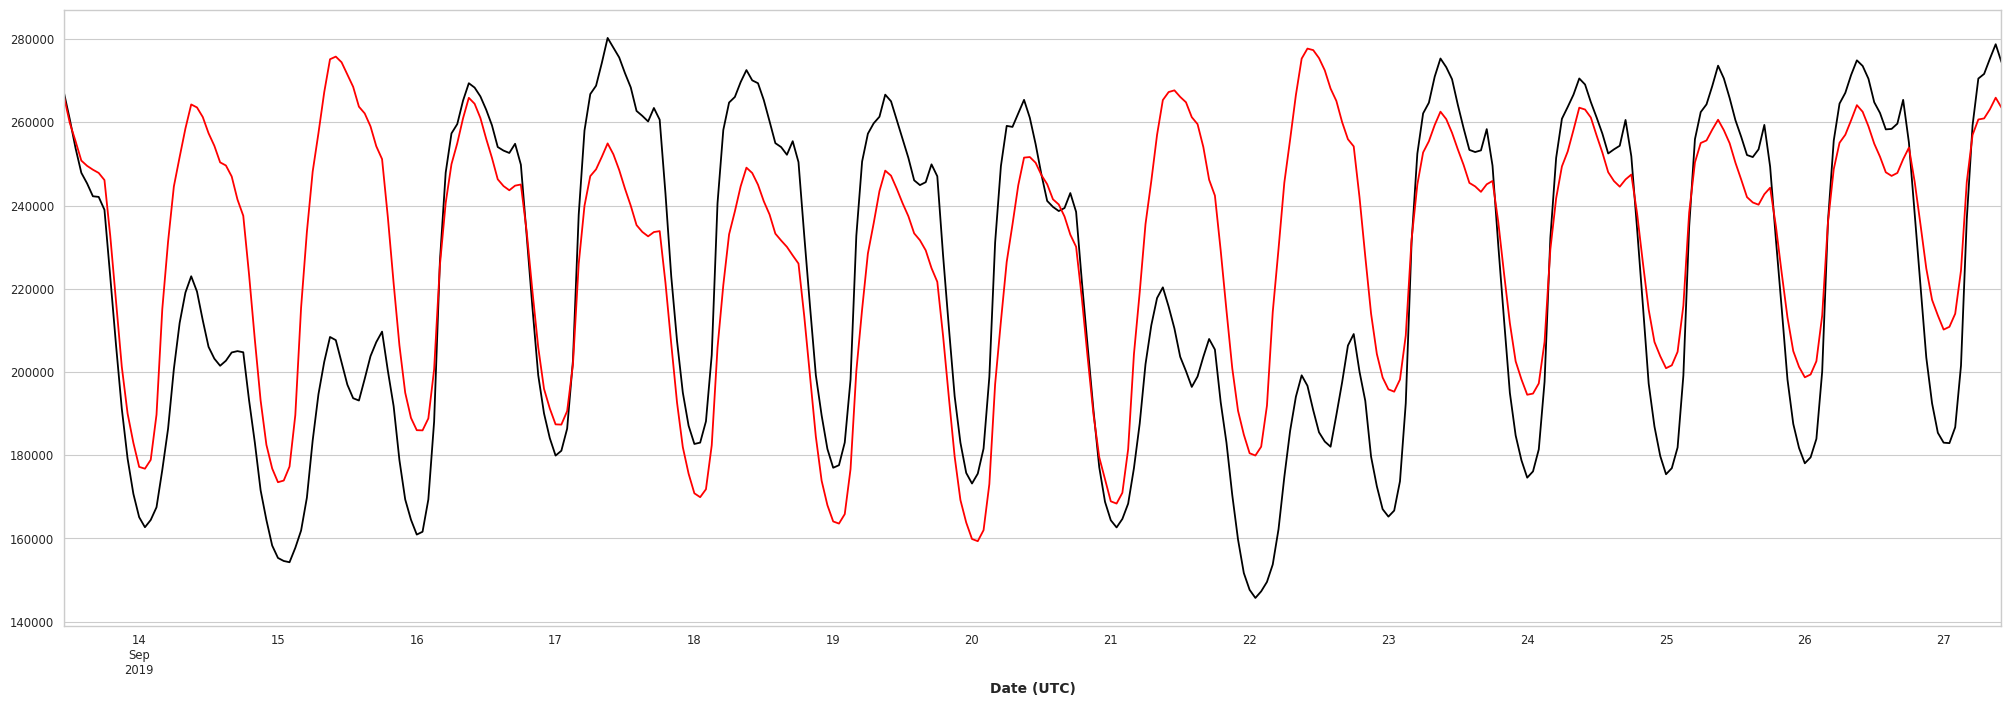

In [37]:
sarimax_prediction_week = result.get_prediction(
    start=test_set.index[0], end=test_set.index[24*7*2-1],
    exog=test_set[:24*7*2][['Temperature','hour', 'is_weekend']],
).predicted_mean

test_set[:24*7*2]["Load"].plot()
sarimax_prediction_week.plot(color='red')
plt.show()

## Evaluation

In [38]:
sys.path.append('../3_Models')
from helper_functions import create_error_metrics

error_metrics_sarimax = create_error_metrics(test_set["Load"], sarimax_prediction)
error_metrics_sarimax_week = create_error_metrics(test_set[:24*7*2]["Load"], sarimax_prediction_week)
print(error_metrics_sarimax)
print(error_metrics_sarimax_week)

        MAE           MSE      RMSE  MAPE %   R2 %
0  29082.02  1.262166e+09  35526.97    13.2  19.51
        MAE           MSE      RMSE  MAPE %   R2 %
0  22818.45  8.840221e+08  29732.51   11.23  37.65


___